In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
!pip install torchsde

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 9.5 MB/s eta 0:00:00

[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


Want to cancel $m$ terms

$\sum_{i=1}^{m} (-1)^{i-1} \begin{pmatrix} m + 1 \\ i \end{pmatrix} x_{m / i}$

In [97]:
from typing import Optional, Dict
from fab.types_ import LogProbFunc

import scipy
import torch
import torch.nn as nn
import torch.nn.functional as f
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from torch.distributions.normal import Normal
from fab.target_distributions.base import TargetDistribution
from fab.utils.numerical import MC_estimate_true_expectation, quadratic_function, \
    importance_weighted_expectation, effective_sample_size_over_p, setup_quadratic_function


class VEReverseSDE(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'
    
    def __init__(self, score_net):
        super().__init__()
        self.score_model = score_net
    
    def f(self, t, x):
        # pdb.set_trace()
        t = t.repeat(len(x)).to(x.device)
        score = self.score_model(x, 1-t)
        return self.g(t, x).pow(2) * score 
    
    def g(self, t, x):
        return torch.full_like(x, beta ** 0.5) #+ 0.1
    
def estimate_pt(_x, _t, num_mc_samples, beta):
    repeated_x = _x.repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.repeat_interleave(num_mc_samples, dim=0)
    h_t = beta * repeated_t

    # samples = repeated_x + torch.normal(torch.zeros_like(repeated_x), h_t.unsqueeze(1) ** 0.5)
    samples = repeated_x + torch.randn_like(repeated_x) * h_t ** 0.5
    log_rewards = normal.log_pdf(samples)#unnormalize(samples, global_mins, global_maxs))

    return torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)

def estimate_pt_anderson(_x, _t, num_mc_samples, beta, terms_to_cancel=1):    
    out_val = torch.zeros((1,), device=_x.device)
    for i in range(1, terms_to_cancel + 2):
        assert num_mc_samples % i == 0
        num_to_measure = int(num_mc_samples / i)
        
        repeated_x = _x.repeat_interleave(num_to_measure, dim=0)
        repeated_t = _t.repeat_interleave(num_to_measure, dim=0)
        h_t = beta * repeated_t

        # samples = repeated_x + torch.normal(torch.zeros_like(repeated_x), h_t.unsqueeze(1) ** 0.5)
        samples = repeated_x + torch.randn_like(repeated_x) * h_t ** 0.5
        log_rewards = normal.log_pdf(samples)#unnormalize(samples, global_mins, global_maxs))
        
        sign = np.power(-1, i - 1)
        coefficient = scipy.special.comb(terms_to_cancel + 1, i)
        iterate = torch.logsumexp(log_rewards, dim=-1) - np.log(num_to_measure)
        
        out_val = out_val + (sign * coefficient * iterate)
        
    return out_val

def estimate_pt_mlmc(_x, _t, beta, alpha=1.0):
    geom_prob = 1 - (2 ** (-(1 + (float(alpha) / 2))))
    k = np.random.geometric(geom_prob)
    num_to_sample = 2 ** (k + 1)
    
    repeated_x = _x.repeat_interleave(num_to_sample, dim=0)
    repeated_t = _t.repeat_interleave(num_to_sample, dim=0)
    h_t = beta * repeated_t

    samples = repeated_x + torch.randn_like(repeated_x) * h_t ** 0.5
    log_rewards = normal.log_pdf(samples)
    
    even_idx = torch.arange(0, num_to_sample, step=2)
    odd_idx = even_idx + 1
    
    all_est = torch.logsumexp(log_rewards, dim=-1) - np.log(num_to_sample)
    even_est = torch.logsumexp(log_rewards[even_idx], dim=-1) - np.log(num_to_sample) + np.log(2)
    odd_est = torch.logsumexp(log_rewards[odd_idx], dim=-1) - np.log(num_to_sample) + np.log(2)
    
    delta = all_est - (0.5 * (even_est + odd_est))
    num_sample_prob = ((1 - geom_prob) ** (k - 1)) * geom_prob
    
    return delta / num_sample_prob

def estimate_pt_jensen(_x, _t, num_mc_samples, beta):
    repeated_x = _x.repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.repeat_interleave(num_mc_samples, dim=0)
    h_t = beta * repeated_t

    # samples = repeated_x + torch.normal(torch.zeros_like(repeated_x), h_t.unsqueeze(1) ** 0.5)
    samples = repeated_x + torch.randn_like(repeated_x) * h_t ** 0.5
    log_rewards = target_distrib.log_prob(samples)#unnormalize(samples, global_mins, global_maxs))

    return log_rewards.mean(dim=-1)

def estimate_pt_IS(_x, _t, is_mean, is_var, num_mc_samples, beta):
    repeated_x = _x.repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.repeat_interleave(num_mc_samples, dim=0)
    h_t = beta * repeated_t
    
    is_means = torch.full((num_mc_samples,), fill_value=is_mean)
    is_vars = torch.full_like(is_means, fill_value=is_var)

    orig_sample_distrib = MyNormal(_x, h_t[0])
    is_sample_distrib = MyNormal(is_mean, is_var)

    samples = is_means + (torch.randn(repeated_x.shape).to(device) * is_vars.sqrt())
    log_rewards = target_distrib.log_prob(samples)#unnormalize(samples, global_mins, global_maxs))
    log_importance_weights = orig_sample_distrib.log_pdf(samples) - is_sample_distrib.log_pdf(samples)

    return torch.logsumexp(
        torch.logsumexp(log_importance_weights + log_rewards, dim=0) - np.log(num_mc_samples), 
        dim=0
    )

def estimate_grad_Rt(x, t, beta=1.0, num_mc_samples=100):
    device = x.device
    def grad_fxn(_x, _t):
        repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
        repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
        h_t = beta * repeated_t
        
        # samples = repeated_x + torch.normal(torch.zeros_like(repeated_x), h_t.unsqueeze(1) ** 0.5)
        samples = repeated_x + torch.randn(repeated_x.shape).to(device) * h_t.unsqueeze(1) ** 0.5
        log_rewards = target_distrib.log_prob(samples)#unnormalize(samples, global_mins, global_maxs))
        
        mean_reward = torch.logsumexp(torch.logsumexp(log_rewards, dim=0) - np.log(num_mc_samples), dim=0)
        return mean_reward
    
    t = t * torch.ones(x.shape[0]).to(device)
    est_scores = torch.vmap(torch.func.grad(grad_fxn), randomness='different')(x, t)
    return est_scores

def estimate_grad_Rt_IS(x, t, is_mean, is_var, beta=1.0, num_mc_samples=100):
    device = x.device
    def grad_fxn(_x, _t):
        repeated_x = _x.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
        repeated_t = _t.unsqueeze(0).repeat_interleave(num_mc_samples, dim=0)
        h_t = beta * repeated_t
        
        # samples = repeated_x + torch.normal(torch.zeros_like(repeated_x), h_t.unsqueeze(1) ** 0.5)
        is_means = torch.full((num_mc_samples,), fill_value=is_mean)
        is_vars = torch.full_like(is_means, fill_value=is_var.item())

        orig_sample_distrib = MyNormal(_x, h_t[0])
        is_sample_distrib = MyNormal(is_mean, is_var)

        samples = is_means + (torch.randn(repeated_x.shape).to(device) * is_vars.sqrt())
        log_rewards = target_distrib.log_prob(samples)#unnormalize(samples, global_mins, global_maxs))
        log_importance_weights = orig_sample_distrib.log_pdf(samples) - is_sample_distrib.log_pdf(samples)

        return torch.logsumexp(
            torch.logsumexp(log_importance_weights + log_rewards, dim=0) - np.log(num_mc_samples), 
            dim=0
        )
        
    t = t * torch.ones(x.shape[0]).to(device)
    est_scores = torch.vmap(torch.func.grad(grad_fxn), randomness='different')(x, t)
    return est_scores

def estimate_grad_Rt_vp(x, t, num_mc_samples=100):
    def grad_fxn(_x, _t):
        h_t = _t.repeat_interleave(num_mc_samples).unsqueeze(1)# / global_maxs
        repeated_x = _x.repeat_interleave(num_mc_samples, dim=0)
        repeated_t = _t.repeat_interleave(num_mc_samples, dim=0)
        
        samples = (repeated_x / (1 - repeated_t).sqrt().unsqueeze(1)) + (torch.normal(torch.zeros_like(repeated_x), h_t.sqrt()).to(device))
        log_rewards = target_distrib.log_prob(samples)#unnormalize(samples, global_mins, global_maxs))
        
        return torch.logsumexp(log_rewards, dim=-1) - np.log(num_mc_samples)
    
    t = t * torch.ones(x.shape[0]).to(device)
    est_scores = torch.vmap(torch.func.grad(grad_fxn), randomness='different')(x, t)
    return est_scores

def true_Rt(x, t, beta):
    h_t = t * beta
    convolved_distrib = Normal(target_distrib.mean, (target_distrib.scale.pow(2) + h_t[0]) ** 0.5)
    return convolved_distrib.log_prob(x)

def true_Rt_vp(x, h_t):
    target_distrib.convolve(h_t)
    energy = target_distrib.log_prob(x / (1 - h_t).sqrt())#unnormalize(x / (1 - t).sqrt(), global_mins, global_maxs))
    target_distrib.reset()
    return energy

def true_grad_Rt(x, h_t):
    with torch.enable_grad():
        x.requires_grad_()
        samples_energy = true_Rt(x, h_t, beta)
        true_scores = torch.autograd.grad(samples_energy.sum(), x, retain_graph=True)[0].detach()
    return true_scores.detach()

def true_grad_Rt_vp(x, h_t, global_mins=-50, global_maxs=50):
    samples_energy = true_Rt_vp(x, h_t)
    true_scores = torch.autograd.grad(samples_energy.sum(), x, retain_graph=True)[0].detach()
    return true_scores
        
def reward_matching_loss(target, vectorfield, constant_noise_scale, x, t):     
    t = t.unsqueeze(1)
    h_t = constant_noise_scale * t
    
    x.requires_grad = True

    # noisy sample: x(t)
    noisy_x = torch.normal(x, h_t ** 0.5)
    pred_scores = vectorfield(noisy_x, t.squeeze())

    estimated_scores = estimate_grad_Rt(noisy_x, t.squeeze(1), beta, 100)
    return ((estimated_scores - pred_scores)**2).mean()

class VEReverseSDE(torch.nn.Module):
    noise_type = 'diagonal'
    sde_type = 'ito'
    
    def __init__(self, score_net):
        super().__init__()
        self.score_model = score_net
    
    def f(self, t, x):
        # pdb.set_trace()
        t = t.repeat(len(x)).to(x.device)
        score = self.score_model(x, 1-t)
        return self.g(t, x).pow(2) * score 
    
    def g(self, t, x):
        return torch.full_like(x, beta ** 0.5) #+ 0.1

In [21]:
target_distrib = Normal(torch.tensor([0.0]), torch.tensor([1.0]), validate_args=False)

In [56]:
x = torch.tensor([1000.0])
t = torch.tensor([0.99])
beta = 10.0
device = torch.device('cpu')

In [85]:
def run(num_samples, fxn=estimate_pt):
    est_vals = torch.tensor([fxn(x, t, num_mc_samples=num_samples, beta=beta) for _ in range(1000)])
    return est_vals.mean(), est_vals.std()

In [106]:
estimate_pt_IS(x, t, 100.0, (beta * t).item(), 100, beta)

TypeError: full_like(): argument 'fill_value' must be Number, not Tensor

In [58]:
true_val

tensor([-45873.6719])

In [100]:
true_grad_Rt(x, t)

tensor([-91.7431])

In [104]:
estimate_grad_Rt_IS(x, t, 100.0, beta * t, beta=beta, num_mc_samples=100)

tensor([-91.7252], grad_fn=<SumBackward1>)

In [102]:
estimate_grad_Rt(x, t, beta=beta, num_mc_samples=100)

tensor([-1002.2487], grad_fn=<SqueezeBackward2>)

In [86]:
means, stds = [], []
jensen_means, jensen_stds = [], []
jensen2_means, jensen2_stds = [], []
jensen3_means, jensen3_stds = [], []
mc_samples = [120, 1200, 12000, 120000]
for i in mc_samples:
    mean, std = run(i)
    means.append(mean)
    stds.append(std)
    
    jen_mean, jen_std = run(i, estimate_pt_anderson)
    jensen_means.append(jen_mean)
    jensen_stds.append(jen_std)
    
    fxn = partial(estimate_pt_anderson, terms_to_cancel=2)
    jen2_mean, jen2_std = run(i, fxn)
    jensen2_means.append(jen2_mean)
    jensen2_stds.append(jen2_std)
    
    fxn = partial(estimate_pt_anderson, terms_to_cancel=5)
    jen3_mean, jen3_std = run(i, fxn)
    jensen3_means.append(jen3_mean)
    jensen3_stds.append(jen3_std)
    
means = torch.tensor(means)
stds = torch.tensor(stds)

jensen_means = torch.tensor(jensen_means)
jensen_stds = torch.tensor(jensen_stds)

jensen2_means = torch.tensor(jensen2_means)
jensen2_stds = torch.tensor(jensen2_stds)

jensen3_means = torch.tensor(jensen3_means)
jensen3_stds = torch.tensor(jensen3_stds)

In [57]:
true_val = true_Rt(x, t, beta)

Text(0.5, 1.0, 'Estimated $p_t(x) = p_0(x) * \\mathcal{N}(0, \\beta t)$ at $x = 15.0$ and $t = 0.99$, $p_0(x) = \\mathcal{N}(0, 1)$, $\\beta = 10$')

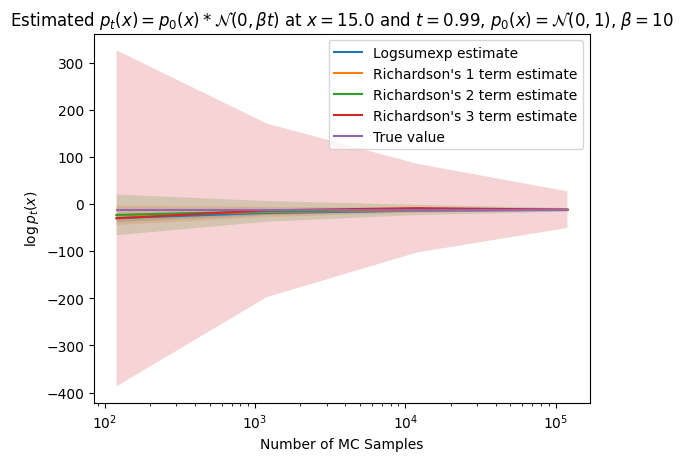

In [88]:
x_vals = np.array(mc_samples)
plt.plot(x_vals, means.cpu(), label='Logsumexp estimate')
plt.fill_between(x_vals, (means - stds).cpu(), (means + stds).cpu(), alpha=0.2)

plt.plot(x_vals, jensen_means.cpu(), label='Richardson\'s 1 term estimate')
plt.fill_between(x_vals, (jensen_means - jensen_stds).cpu(), (jensen_means + jensen_stds).cpu(), alpha=0.2)

plt.plot(x_vals, jensen2_means.cpu(), label='Richardson\'s 2 term estimate')
plt.fill_between(x_vals, (jensen2_means - jensen2_stds).cpu(), (jensen2_means + jensen2_stds).cpu(), alpha=0.2)

plt.plot(x_vals, jensen3_means.cpu(), label='Richardson\'s 3 term estimate')
plt.fill_between(x_vals, (jensen3_means - jensen3_stds).cpu(), (jensen3_means + jensen3_stds).cpu(), alpha=0.2)


plt.plot(x_vals, torch.full_like(means, fill_value=true_val.item()), label='True value')
plt.xscale('log')
plt.legend()

plt.ylabel(r'$\log p_t(x)$')
plt.xlabel('Number of MC Samples')

plt.title(r'Estimated $p_t(x) = p_0(x) * \mathcal{N}(0, \beta t)$ at $x = %.1f$ and $t = %.2f$, $p_0(x) = \mathcal{N}(0, 1)$, $\beta = 10$' % (x.item(), t.item()))

### Findings so far:
The farther away the thing we're measuring is from the $p_0$ distribution the more the bias is as well as the longer it takes to correct for the bias... Is there a way to analytically correct the bias?

$f(x) = \frac{1}{\sigma\sqrt{2\pi}} \exp\left( -\frac{1}{2}\left(\frac{x-\mu}{\sigma}\right)^{\!2}\,\right)$

In [84]:
class MyNormal:
    def __init__(self, mean, var):
        self.mean = mean
        self.var = var
        
    def pdf(self, point):
        normalization = 1 / (2 * np.pi * self.var).sqrt()
        exp_arg = -0.5 * ((point - self.mean).pow(2) / self.var)
        
        return normalization * exp_arg.exp()
    
    def log_pdf(self, point):
        log_norm = -(2 * np.pi * self.var).sqrt().log()
        exp_arg = -0.5 * ((point - self.mean).pow(2) / self.var)
        
        return exp_arg + log_norm
    
    def get_convolved_dist(self, t, beta):
        h_t = t * beta
        return MyNormal(self.mean, self.var + h_t)

In [65]:
normal = MyNormal(torch.tensor([0.0]), torch.tensor([1.0]))

In [230]:
normal.pdf(torch.tensor([-13.0]))

tensor([7.9988e-38])

In [225]:
target_distrib.log_prob(torch.tensor([0.0]))

tensor([-0.9189])

In [7]:
def estimate_pt_non_log(_x, _t, num_mc_samples, beta):
    repeated_x = _x.repeat_interleave(num_mc_samples, dim=0)
    repeated_t = _t.repeat_interleave(num_mc_samples, dim=0)
    h_t = beta * repeated_t

    # samples = repeated_x + torch.normal(torch.zeros_like(repeated_x), h_t.unsqueeze(1) ** 0.5)
    samples = repeated_x + torch.randn_like(repeated_x) * h_t ** 0.5
    rewards = normal.pdf(samples)#unnormalize(samples, global_mins, global_maxs))

    return rewards.mean(dim=-1)

In [17]:
means, stds = [], []
alphas = range(1, 11)
for i in alphas:
    val = torch.tensor([estimate_pt_mlmc(x, t, beta=beta, alpha=i) for _ in range(1000)])
    means.append(val.mean())
    stds.append(val.std())
    
means = torch.tensor(means)
stds = torch.tensor(stds)

In [18]:
means

tensor([6626.4639, 6042.3501, 4809.6577, 9306.0957, 3744.3655, 3356.8652,
        3575.2544, 2631.0586, 4944.6270, 3478.3545])

In [19]:
stds

tensor([ 22406.8320,  36736.0039,  18247.1133, 101358.2812,  14564.5918,
          9443.2314,  21722.6504,   8918.0557,  74586.3047,  16377.4727])

In [242]:
means, stds = [], []
mc_samples = [10, 100, 1000, 10000, 100000]
for i in mc_samples:
    mean, std = run(i, estimate_pt_non_log)
    means.append(mean)
    stds.append(std)
    
means = torch.tensor(means)
stds = torch.tensor(stds)

Text(0.5, 0, 'Number of MC Samples')

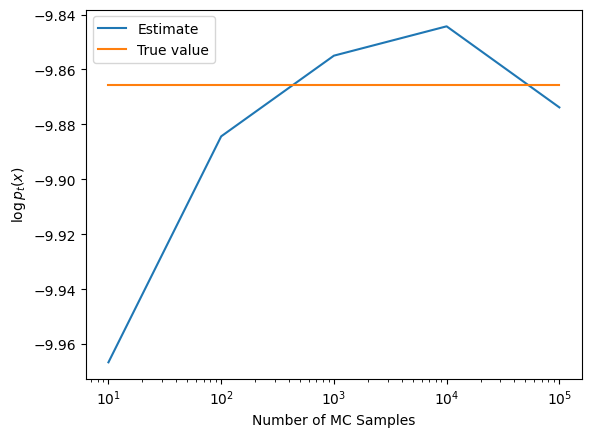

In [245]:
x_vals = np.array(mc_samples)
plt.plot(x_vals, means.cpu().log(), label='Estimate')
#plt.fill_between(x_vals, (means - stds).cpu(), (means + stds).cpu(), alpha=0.2)

plt.plot(x_vals, torch.full_like(means, fill_value=true_val.item()), label='True value')
plt.xscale('log')
plt.legend()

plt.ylabel(r'$\log p_t(x)$')
plt.xlabel('Number of MC Samples')

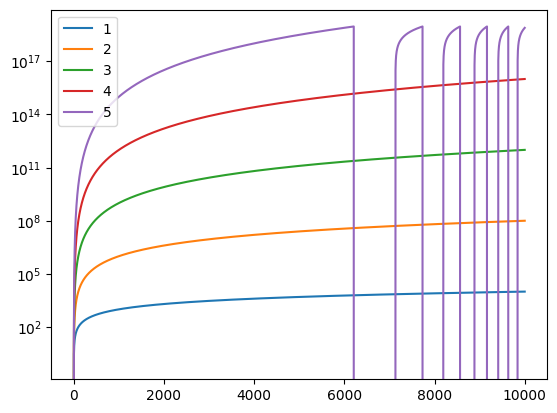

In [303]:
x = np.arange(10000)

for i in range(1, 6):
    plt.plot(x, np.power(x, i), label=f'{i}')
plt.legend()
plt.yscale('log')

In [63]:
x1_samples = torch.normal(torch.zeros(1000), torch.full((1000,), fill_value=500.0))

In [58]:
import torchsde

beta = 5.0
num_mc_samples = 100
def est_ve_score_wrapper(x, t):
    with torch.enable_grad():
        return estimate_grad_Rt(x, t, beta=beta, num_mc_samples=num_mc_samples)

ve_sde_est_score = VEReverseSDE(true_grad_Rt)

t = torch.linspace(0.0, 1.0, 500)
with torch.no_grad():
    samples = torchsde.sdeint(ve_sde_est_score, x1_samples.unsqueeze(1), t, method='euler')

In [66]:
import torchsde

beta = 500.0
num_mc_samples = 100
def est_ve_score_wrapper(x, t):
    with torch.enable_grad():
        return estimate_grad_Rt(x, t, beta=beta, num_mc_samples=num_mc_samples)

ve_sde_est_score = VEReverseSDE(est_ve_score_wrapper)

t = torch.linspace(0.0, 1.0, 500)
with torch.no_grad():
    est_samples = torchsde.sdeint(ve_sde_est_score, x1_samples.unsqueeze(1), t, method='euler')

RuntimeError: Cannot access data pointer of Tensor that doesn't have storage

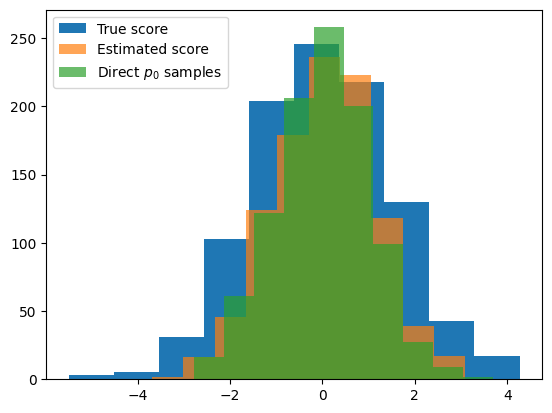

In [46]:
plt.hist(samples[-1, :, 0], label='True score')
plt.hist(est_samples[-1, :, 0], label='Estimated score', alpha=0.7)
plt.hist(torch.randn((1000,)), alpha=0.7, label=r'Direct $p_0$ samples')
plt.legend()

Text(0.5, 1.0, 'Estimated score trajectories')

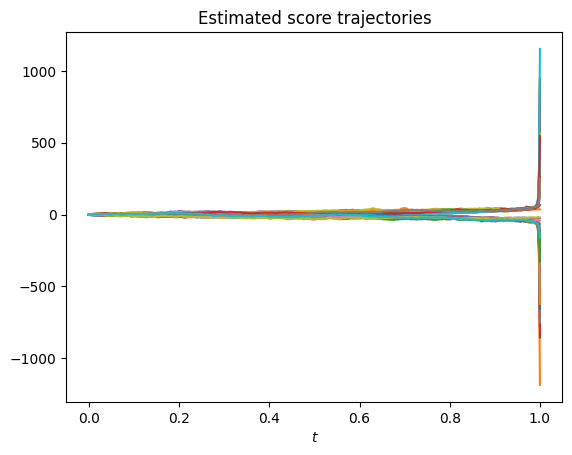

In [47]:
for i in range(50): 
    plt.plot(1 - t, est_samples[:, i, 0])
    
plt.xlabel(r'$t$')
plt.title('Estimated score trajectories')
#plt.yscale('log')

Text(0.5, 1.0, 'True score trajectories')

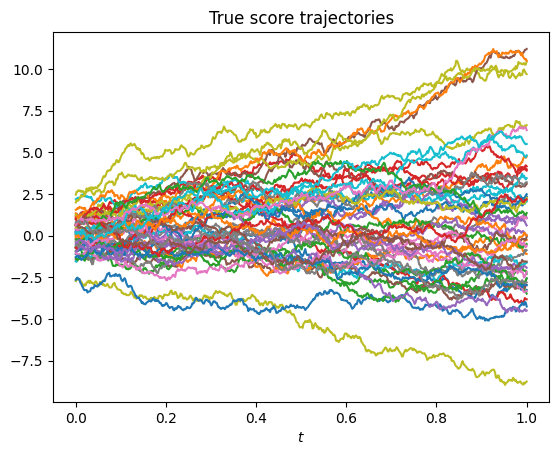

In [59]:
for i in range(50): 
    plt.plot(1 - t, samples[:, i, 0])
    
plt.xlabel(r'$t$')
plt.title('True score trajectories')

#plt.yscale('log')

In [18]:
samples.shape

torch.Size([500, 1000, 1])

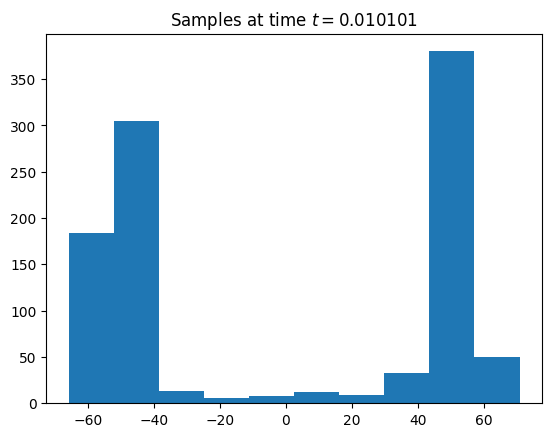

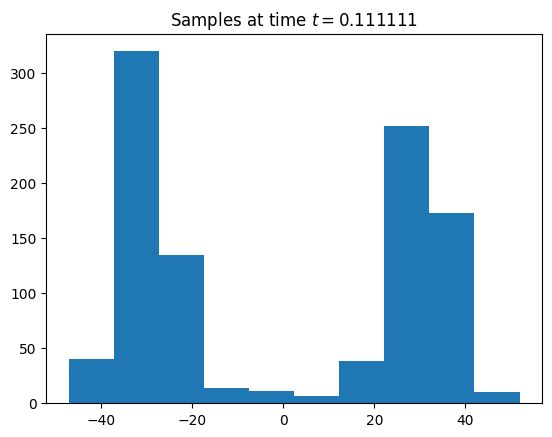

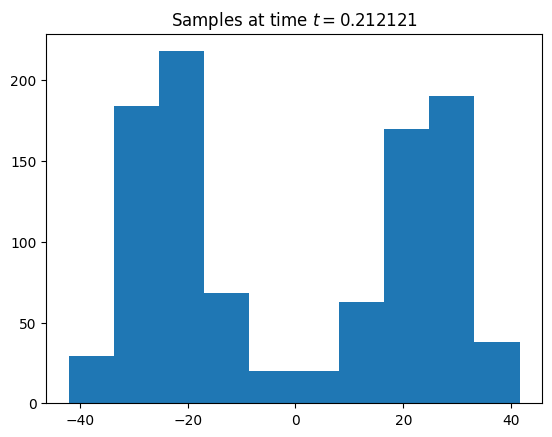

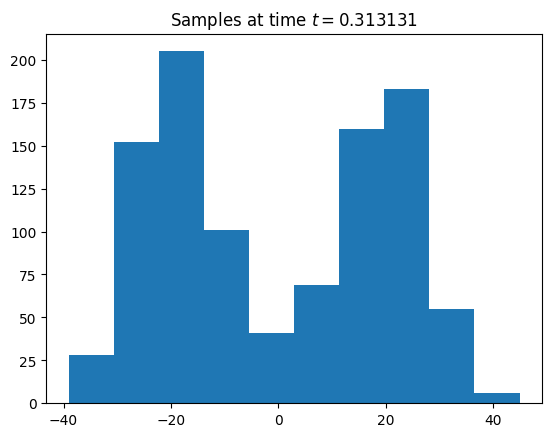

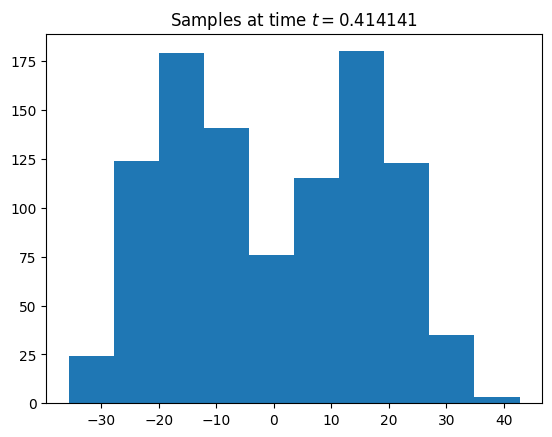

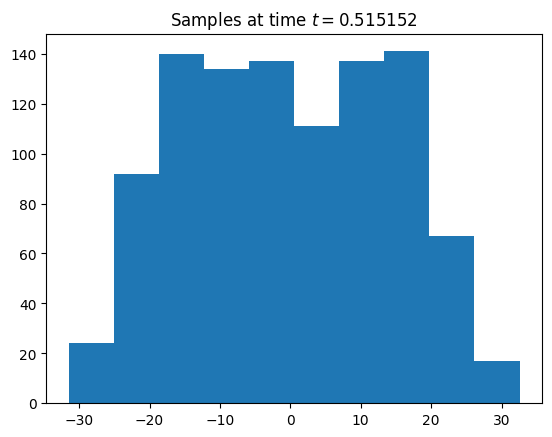

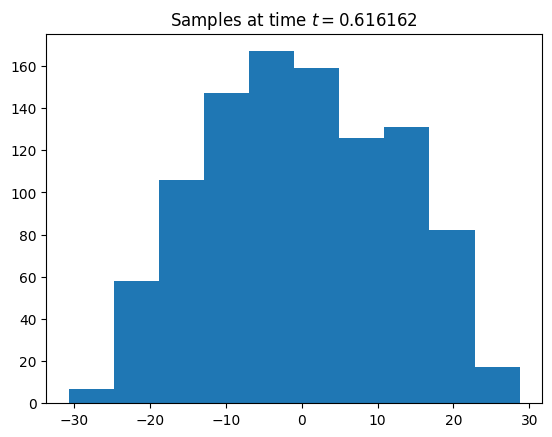

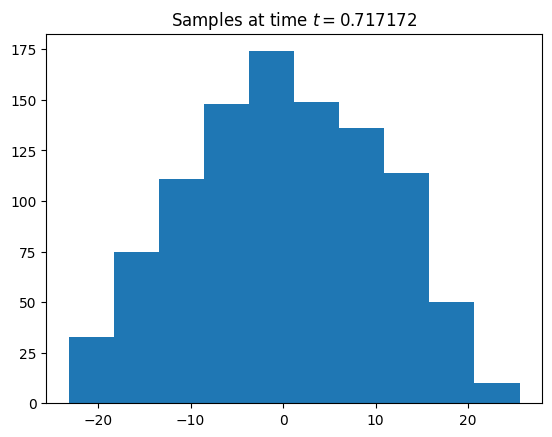

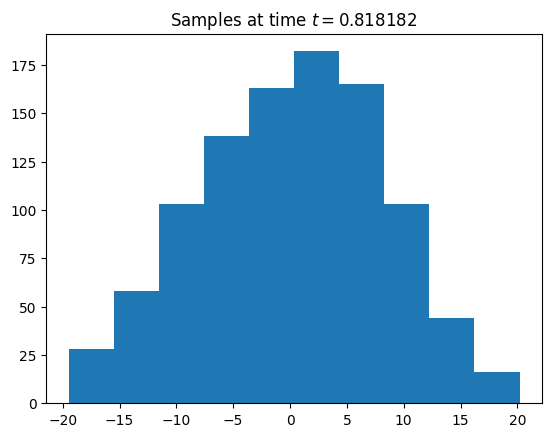

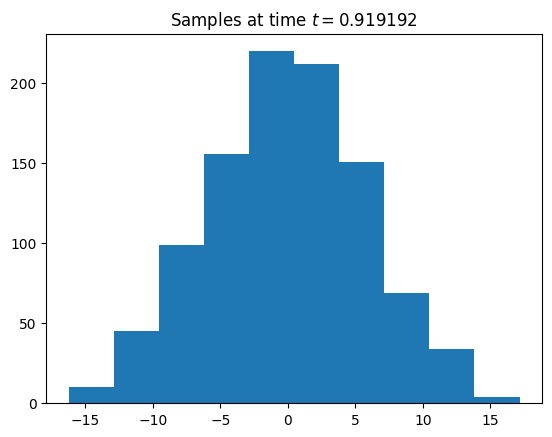

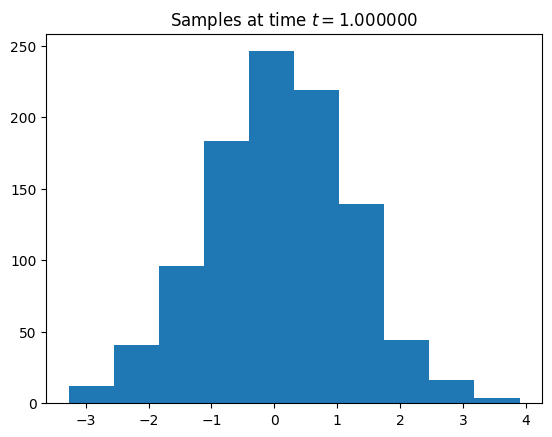

In [18]:
t = torch.linspace(0.0, 1.0, 100)
for i in range(1, 101, 10):
    plt.hist(samples[i, :, 0])
    plt.title(r'Samples at time $t = %f$' % t[i])
    plt.show()
    
plt.hist(samples[-1, :, 0])
plt.title(r'Samples at time $t = %f$' % t[-1])
plt.show()

In [425]:
samples.shape

torch.Size([100, 100, 1])

(array([  7.,  17.,  71., 125., 192., 234., 182.,  99.,  54.,  19.]),
 array([-1598.90405273, -1298.47766113,  -998.05126953,  -697.62481689,
         -397.19842529,   -96.77203369,   203.65437317,   504.08078003,
          804.50720215,  1104.93359375,  1405.35998535]),
 <BarContainer object of 10 artists>)

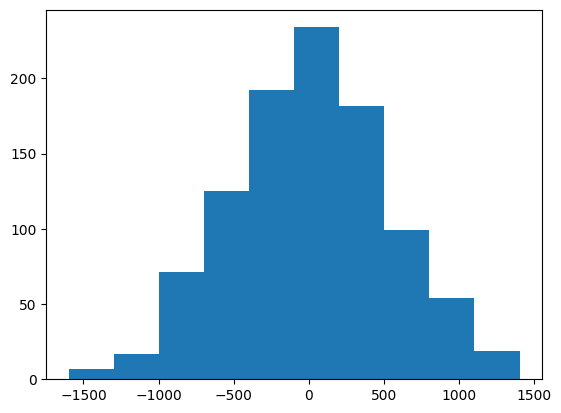

In [436]:
plt.hist(x1_samples)

In [435]:
x1_samples.shape

torch.Size([1000])

## Playing with Multilevel Monte Carlo

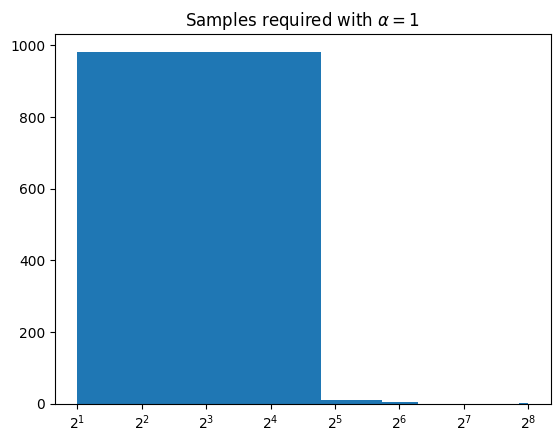

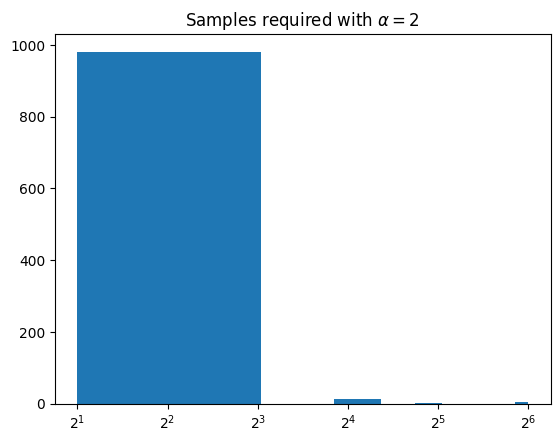

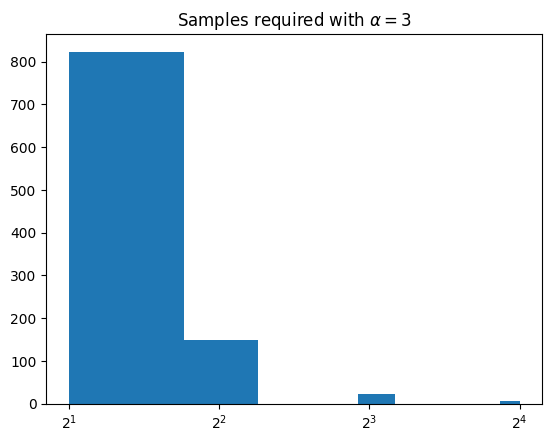

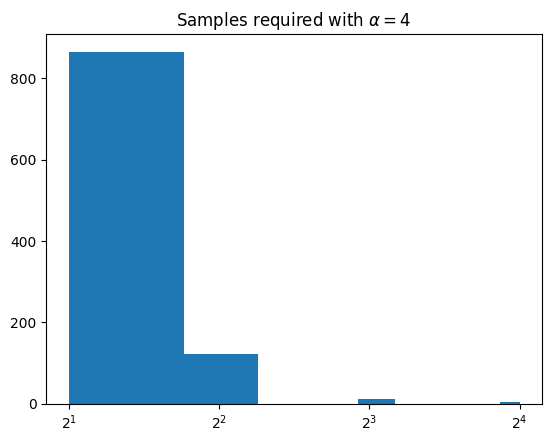

In [15]:
for alpha in range(1, 5):
    r = 1 - (2 ** (-(1 + (float(alpha) / 2))))
    required_samples = 2 ** torch.empty((1000,)).geometric_(r)
    
    plt.hist(required_samples)
    plt.title(r'Samples required with $\alpha = %d$' % alpha)
    plt.xscale('log', base=2)
    plt.show()
                        

In [9]:
(2 ** torch.empty((1000,)).geometric_(1 - (2 ** (-3 / 2)))).max()

tensor(128.)